# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>
>- Python 3.12.7
>- Pandas version: 2.2.3
>- Matplotlib version: 3.10.0
>- Scikit-learn version: 1.6.1


In [2]:
# ### run this cell for version check
# !python --version
# import pandas
# import matplotlib
# import sklearn
# print("Pandas version:", pandas.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Scikit-learn version:", sklearn.__version__)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
# Load data
file_name = "../test_csv/motor_rpm_high.csv"
df = pd.read_csv(file_name, parse_dates=["timestamp"])
tags = df["sensor"].unique()


CUDA_VISIBLE_DEVICES = 0
Physical devices: []
TensorFlow version: 2.19.0
TensorFlow is built with CUDA: False
TensorFlow is using GPU: False


In [4]:
## sikit learn model
from sklearn.ensemble import IsolationForest

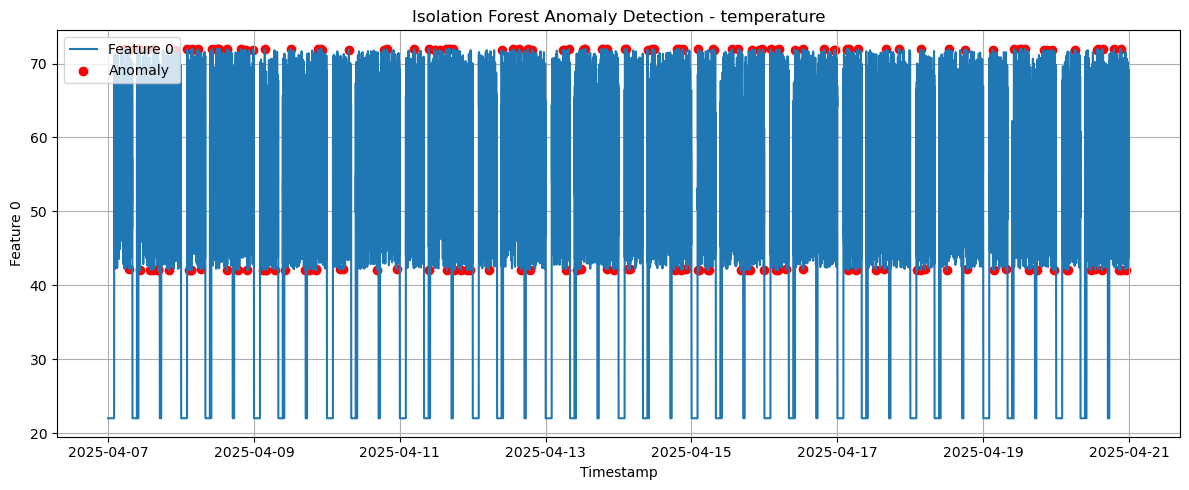

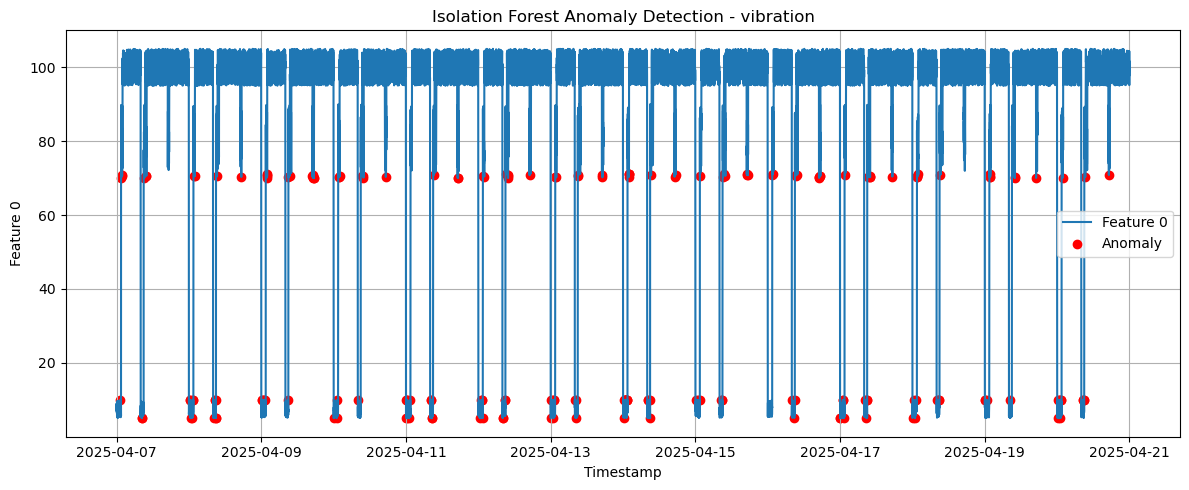

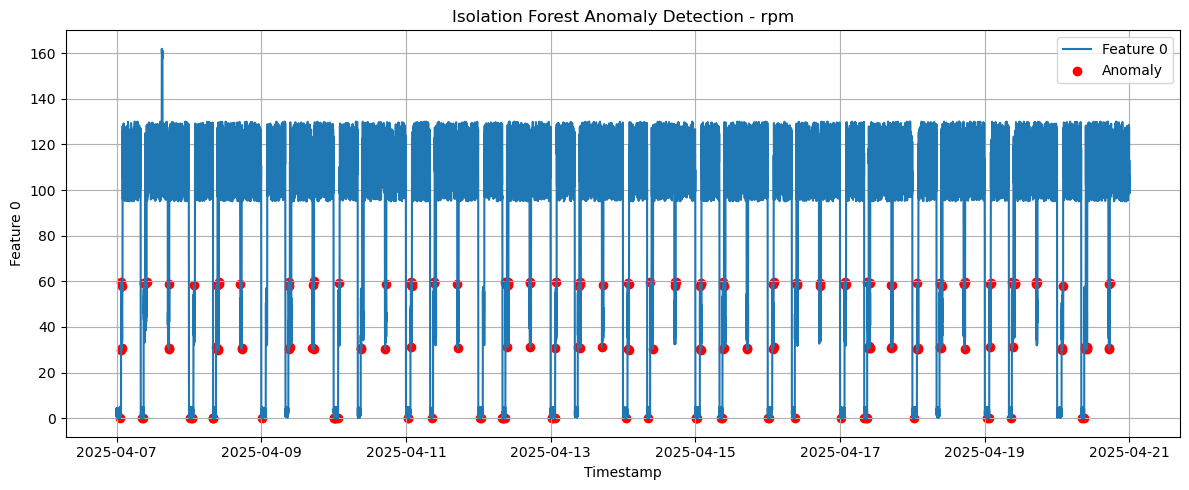

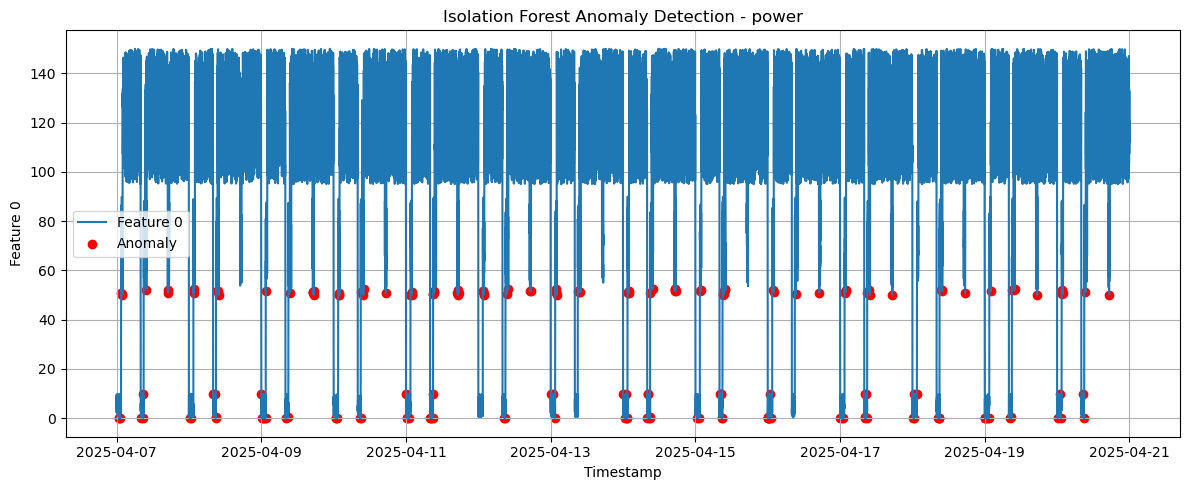

In [5]:
for tag in tags:
    tag_df = df[df["sensor"] == tag].copy()

    # Train only on normal data
    X_train = tag_df[tag_df["is_anomaly"] == False][["feature_0"]]

    # Train Isolation Forest
    model = IsolationForest(contamination=0.01, random_state=42)
    model.fit(X_train)

    # Predict on full tag data
    tag_df["anomaly_label"] = model.predict(tag_df[["feature_0"]])
    tag_df["anomaly_label"] = tag_df["anomaly_label"].map({1: False, -1: True})

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(tag_df["timestamp"], tag_df["feature_0"], label="Feature 0")

    anomalies = tag_df[tag_df["anomaly_label"] == True]
    plt.scatter(anomalies["timestamp"], anomalies["feature_0"], color="red", label="Anomaly")

    plt.title(f"Isolation Forest Anomaly Detection - {tag}")
    plt.xlabel("Timestamp")
    plt.ylabel("Feature 0")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


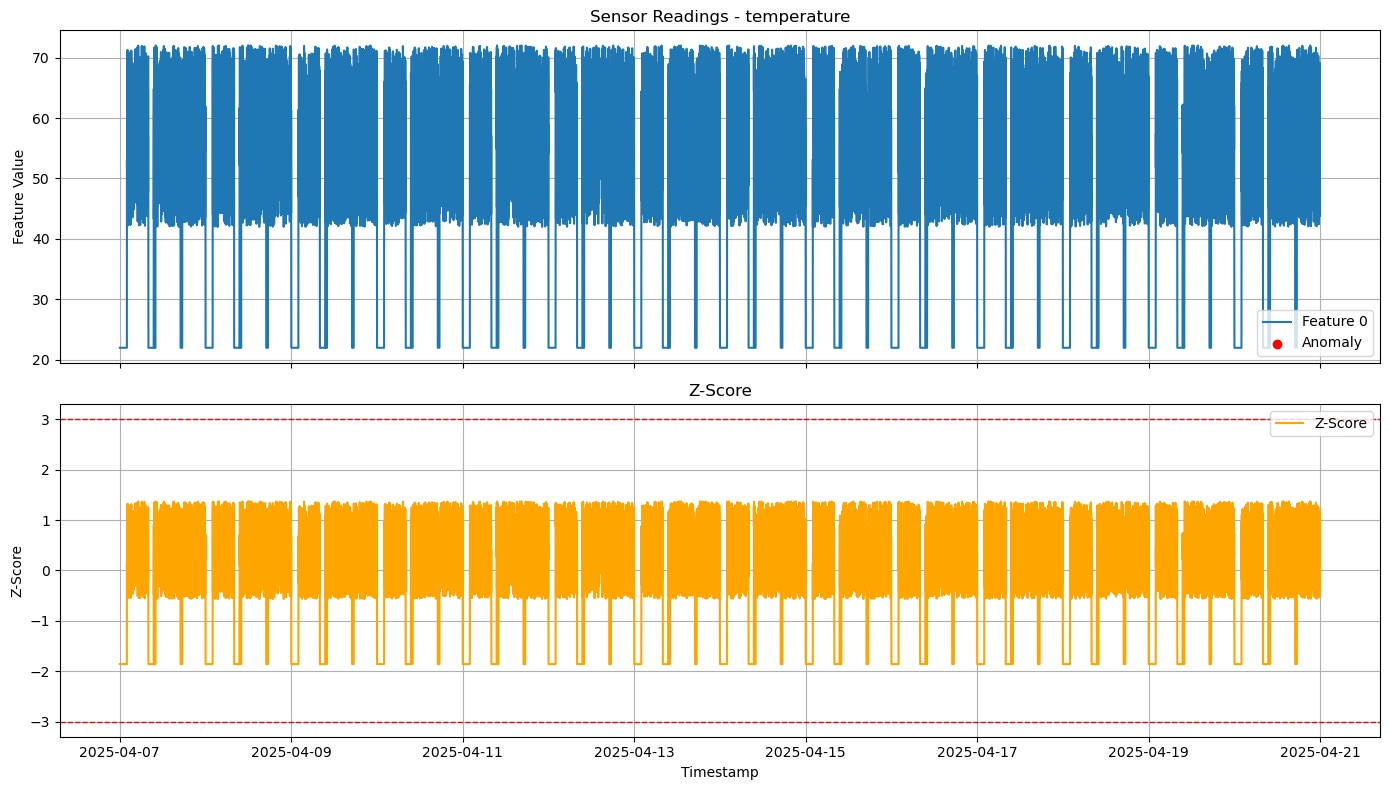

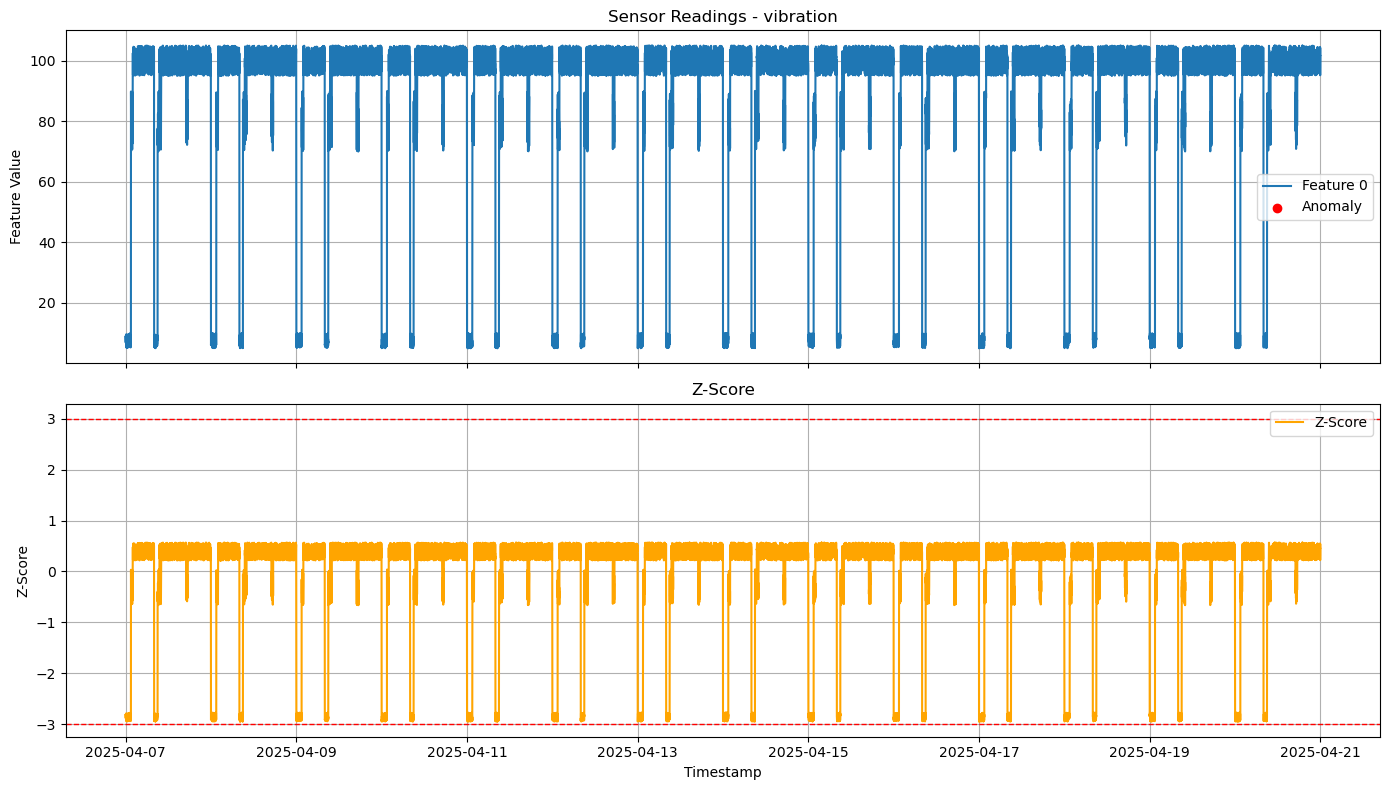

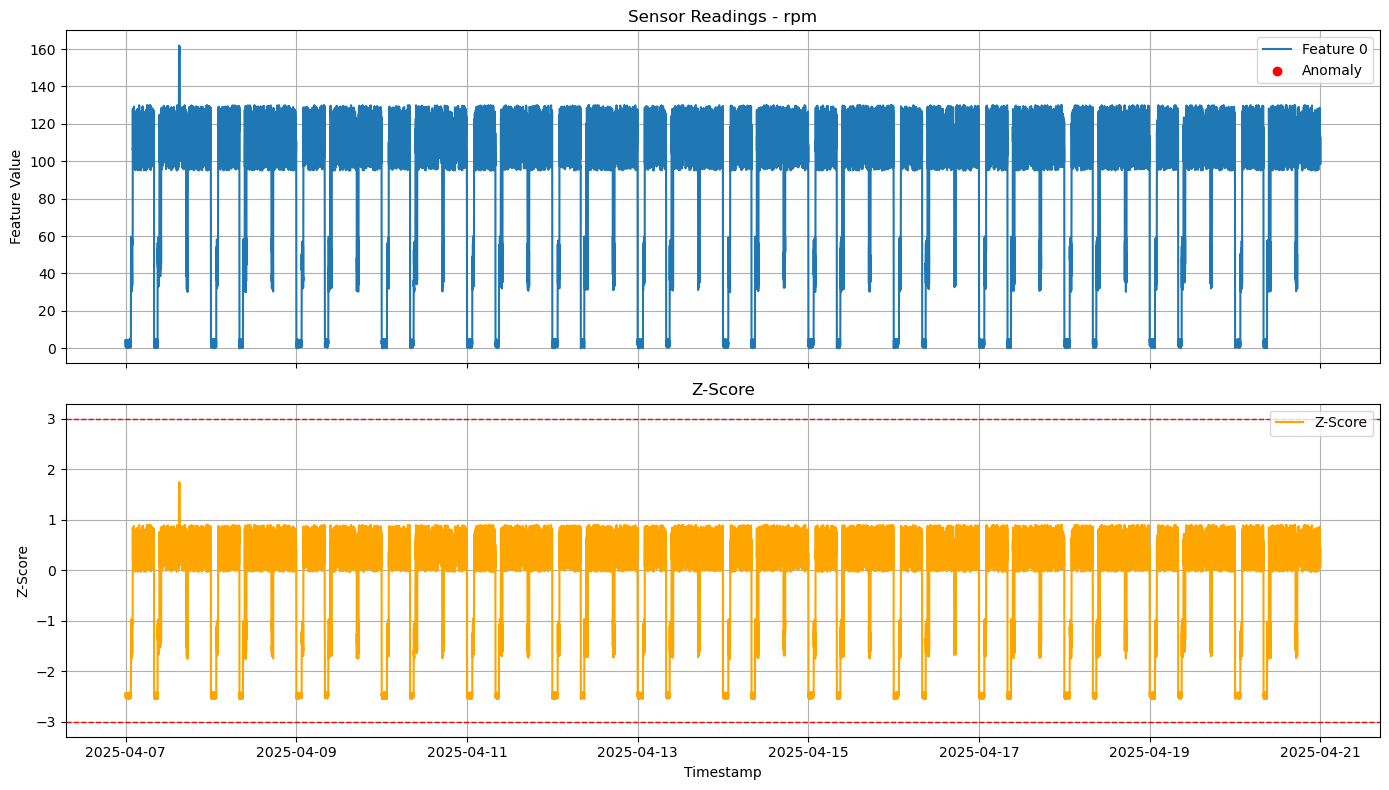

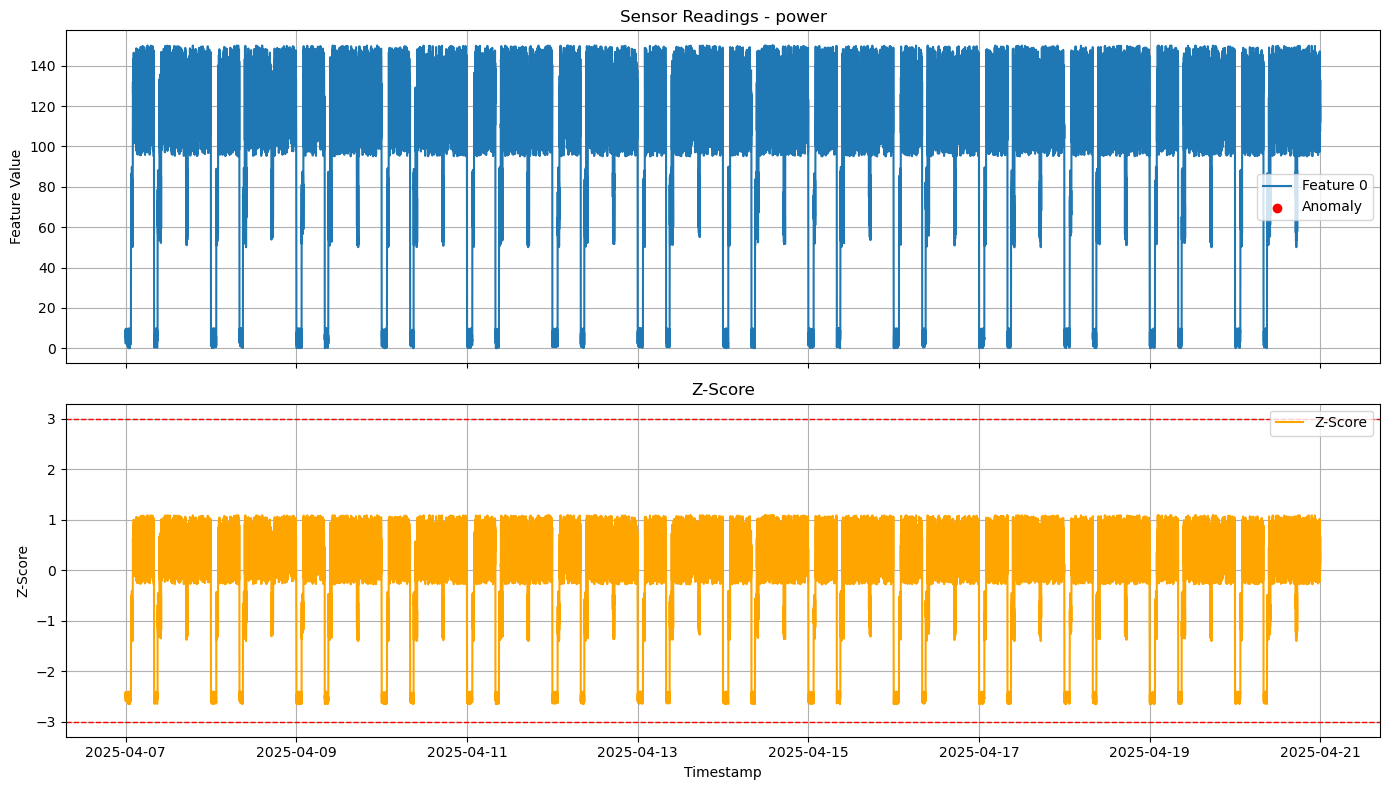

In [6]:
from scipy.stats import zscore

for tag in tags:
    tag_df = df[df["sensor"] == tag].copy()
    tag_df["zscore"] = zscore(tag_df["feature_0"])
    tag_df["anomaly_label"] = tag_df["zscore"].abs() > 3

    anomalies = tag_df[tag_df["anomaly_label"] == True]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # --- Plot 1: Feature values
    ax1.plot(tag_df["timestamp"], tag_df["feature_0"], label="Feature 0")
    ax1.scatter(anomalies["timestamp"], anomalies["feature_0"], color="red", label="Anomaly", zorder=5)
    ax1.set_title(f"Sensor Readings - {tag}")
    ax1.set_ylabel("Feature Value")
    ax1.legend()
    ax1.grid(True)

    # --- Plot 2: Z-Score
    ax2.plot(tag_df["timestamp"], tag_df["zscore"], color="orange", label="Z-Score")
    ax2.axhline(3, color="red", linestyle="--", linewidth=1)
    ax2.axhline(-3, color="red", linestyle="--", linewidth=1)
    ax2.set_title("Z-Score")
    ax2.set_xlabel("Timestamp")
    ax2.set_ylabel("Z-Score")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()